### N-gram language models or how to write scientific papers (4 pts)

We shall train our language model on a corpora of [ArXiv](http://arxiv.org/) articles and see if we can generate a new one!

![img](https://media.npr.org/assets/img/2013/12/10/istock-18586699-monkey-computer_brick-16e5064d3378a14e0e4c2da08857efe03c04695e-s800-c85.jpg)

_data by neelshah18 from [here](https://www.kaggle.com/neelshah18/arxivdataset/)_

_Disclaimer: this has nothing to do with actual science. But it's fun, so who cares?!_

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Alternative manual download link: https://yadi.sk/d/_nGyU2IajjR9-w
# !wget "https://www.dropbox.com/s/99az9n1b57qkd9j/arxivData.json.tar.gz?dl=1" -O arxivData.json.tar.gz
# !tar -xvzf arxivData.json.tar.gz
data = pd.read_json("./arxivData.json")
data.sample(n=5)

,author,day,id,link,month,summary,tag,title,year
12799,"[{'name': 'Yair Rivenson'}, {'name': 'Zoltan G...",12,1705.04709v1,"[{'rel': 'related', 'href': 'http://dx.doi.org...",5,We demonstrate that a deep neural network can ...,"[{'term': 'cs.LG', 'scheme': 'http://arxiv.org...",Deep Learning Microscopy,2017
17741,"[{'name': 'Christian Stab'}, {'name': 'Tristan...",15,1802.05758v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",2,Argument mining is a core technology for autom...,"[{'term': 'cs.CL', 'scheme': 'http://arxiv.org...",Cross-topic Argument Mining from Heterogeneous...,2018
35841,"[{'name': 'Pedro Larrañaga'}, {'name': 'Ramon ...",16,1301.3871v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",1,This paper shows how the Bayesian network para...,"[{'term': 'cs.AI', 'scheme': 'http://arxiv.org...",Combinatorial Optimization by Learning and Sim...,2013
5390,"[{'name': 'Brian McWilliams'}, {'name': 'David...",24,1306.5554v2,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",6,This paper presents Correlated Nystrom Views (...,"[{'term': 'stat.ML', 'scheme': 'http://arxiv.o...",Correlated random features for fast semi-super...,2013
26291,"[{'name': 'Michal Balazia'}, {'name': 'Petr So...",22,1609.06936v4,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",9,"MoCap-based human identification, as a pattern...","[{'term': 'cs.CV', 'scheme': 'http://arxiv.org...",Walker-Independent Features for Gait Recogniti...,2016


In [3]:
# assemble lines: concatenate title and description
lines = data.apply(lambda row: row['title'] + ' ; ' + row['summary'].replace("\n", ' '), axis=1).tolist()

sorted(lines, key=len)[:3]

['Differential Contrastive Divergence ; This paper has been retracted.',
 'What Does Artificial Life Tell Us About Death? ; Short philosophical essay',
 'P=NP ; We claim to resolve the P=?NP problem via a formal argument for P=NP.']

### Tokenization

You know the dril. The data is messy. Go clean the data. Use WordPunctTokenizer or something.


In [4]:
# Task: convert lines (in-place) into strings of space-separated tokens. Import & use WordPunctTokenizer
from nltk.tokenize import WordPunctTokenizer
tokenizer = WordPunctTokenizer()
lines = [' '.join(tokenizer.tokenize(line.lower())) for line in lines]

In [5]:
assert sorted(lines, key=len)[0] == \
    'differential contrastive divergence ; this paper has been retracted .'
assert sorted(lines, key=len)[2] == \
    'p = np ; we claim to resolve the p =? np problem via a formal argument for p = np .'

### N-Gram Language Model (1point)

A language model is a probabilistic model that estimates text probability: the joint probability of all tokens $w_t$ in text $X$: $P(X) = P(w_1, \dots, w_T)$.

It can do so by following the chain rule:
$$P(w_1, \dots, w_T) = P(w_1)P(w_2 \mid w_1)\dots P(w_T \mid w_1, \dots, w_{T-1}).$$ 

The problem with such approach is that the final term $P(w_T \mid w_1, \dots, w_{T-1})$ depends on $n-1$ previous words. This probability is impractical to estimate for long texts, e.g. $T = 1000$.

One popular approximation is to assume that next word only depends on a finite amount of previous words:

$$P(w_t \mid w_1, \dots, w_{t - 1}) = P(w_t \mid w_{t - n + 1}, \dots, w_{t - 1})$$

Such model is called __n-gram language model__ where n is a parameter. For example, in 3-gram language model, each word only depends on 2 previous words. 

$$
    P(w_1, \dots, w_n) = \prod_t P(w_t \mid w_{t - n + 1}, \dots, w_{t - 1}).
$$

You can also sometimes see such approximation under the name of _n-th order markov assumption_.

The first stage to building such a model is counting all word occurences given N-1 previous words

In [6]:
from tqdm import tqdm
from collections import defaultdict, Counter

# special tokens: 
# - `UNK` represents absent tokens, 
# - `EOS` is a special token after the end of sequence

UNK, EOS = "_UNK_", "_EOS_"

def count_ngrams(lines, n):
    """
    Count how many times each word occured after (n - 1) previous words
    :param lines: an iterable of strings with space-separated tokens
    :returns: a dictionary { tuple(prefix_tokens): {next_token_1: count_1, next_token_2: count_2}}

    When building counts, please consider the following two edge cases:
    - if prefix is shorter than (n - 1) tokens, it should be padded with UNK. For n=3,
      empty prefix: "" -> (UNK, UNK)
      short prefix: "the" -> (UNK, the)
      long prefix: "the new approach" -> (new, approach)
    - you should add a special token, EOS, at the end of each sequence
      "... with deep neural networks ." -> (..., with, deep, neural, networks, ., EOS)
      count the probability of this token just like all others.
    """
    counts = defaultdict(Counter)
    # counts[(word1, word2)][word3] = how many times word3 occured after (word1, word2)

    for line in lines:
        line_list = [UNK] * (n - 1) + line.split(' ') + [EOS]
        for end_idx in range(n - 1, len(line_list)):
            counts[tuple(line_list[end_idx - n + 1 : end_idx])].update([line_list[end_idx]])
    
    return counts


In [7]:
dummy_lines = sorted(lines, key=len)[:100]
dummy_counts = count_ngrams(dummy_lines, n=3)

In [8]:
# let's test it
dummy_lines = sorted(lines, key=len)[:100]
dummy_counts = count_ngrams(dummy_lines, n=3)
assert set(map(len, dummy_counts.keys())) == {2}, "please only count {n-1}-grams"
print(len(dummy_counts[('_UNK_', '_UNK_')]))
assert len(dummy_counts[('_UNK_', '_UNK_')]) == 78
assert dummy_counts['_UNK_', 'a']['note'] == 3
assert dummy_counts['p', '=']['np'] == 2
assert dummy_counts['author', '.']['_EOS_'] == 1

78


Once we can count N-grams, we can build a probabilistic language model.
The simplest way to compute probabilities is in proporiton to counts:

$$ P(w_t | prefix) = { Count(prefix, w_t) \over \sum_{\hat w} Count(prefix, \hat w) } $$

In [9]:
class NGramLanguageModel:    
    def __init__(self, lines, n):
        """ 
        Train a simple count-based language model: 
        compute probabilities P(w_t | prefix) given ngram counts
        
        :param n: computes probability of next token given (n - 1) previous words
        :param lines: an iterable of strings with space-separated tokens
        """
        assert n >= 1
        self.n = n
    
        counts = count_ngrams(lines, self.n)
        
        # compute token proabilities given counts
        self.probs = defaultdict(Counter)
        # probs[(word1, word2)][word3] = P(word3 | word1, word2)
        
        # populate self.probs with actual probabilities
        for prefix in counts:
            for word in counts[prefix]:
                self.probs[prefix][word] = counts[prefix][word] / counts[prefix].total()
            
    def get_possible_next_tokens(self, prefix):
        """
        :param prefix: string with space-separated prefix tokens
        :returns: a dictionary {token : it's probability} for all tokens with positive probabilities
        """
        prefix = prefix.split()
        prefix = prefix[max(0, len(prefix) - self.n + 1):]
        prefix = [ UNK ] * (self.n - 1 - len(prefix)) + prefix
        return self.probs[tuple(prefix)]
    
    def get_next_token_prob(self, prefix, next_token):
        """
        :param prefix: string with space-separated prefix tokens
        :param next_token: the next token to predict probability for
        :returns: P(next_token|prefix) a single number, 0 <= P <= 1
        """
        return self.get_possible_next_tokens(prefix).get(next_token, 0)

Let's test it!

In [10]:
dummy_lm = NGramLanguageModel(dummy_lines, n=3)

p_initial = dummy_lm.get_possible_next_tokens('') # '' -> ['_UNK_', '_UNK_']
assert np.allclose(p_initial['learning'], 0.02)
assert np.allclose(p_initial['a'], 0.13)
assert np.allclose(p_initial.get('meow', 0), 0)
assert np.allclose(sum(p_initial.values()), 1)

p_a = dummy_lm.get_possible_next_tokens('a') # '' -> ['_UNK_', 'a']
assert np.allclose(p_a['machine'], 0.15384615)
assert np.allclose(p_a['note'], 0.23076923)
assert np.allclose(p_a.get('the', 0), 0)
assert np.allclose(sum(p_a.values()), 1)

assert np.allclose(dummy_lm.get_possible_next_tokens('a note')['on'], 1)
assert dummy_lm.get_possible_next_tokens('a machine') == \
    dummy_lm.get_possible_next_tokens("there have always been ghosts in a machine"), \
    "your 3-gram model should only depend on 2 previous words"

Now that you've got a working n-gram language model, let's see what sequences it can generate. But first, let's train it on the whole dataset.

In [11]:
lm = NGramLanguageModel(lines, n=3)

The process of generating sequences is... well, it's sequential. You maintain a list of tokens and iteratively add next token by sampling with probabilities.

$ X = [] $

__forever:__
* $w_{next} \sim P(w_{next} | X)$
* $X = concat(X, w_{next})$


Instead of sampling with probabilities, one can also try always taking most likely token, sampling among top-K most likely tokens or sampling with temperature. In the latter case (temperature), one samples from

$$w_{next} \sim {P(w_{next} | X) ^ {1 / \tau} \over \sum_{\hat w} P(\hat w | X) ^ {1 / \tau}}$$

Where $\tau > 0$ is model temperature. If $\tau << 1$, more likely tokens will be sampled with even higher probability while less likely tokens will vanish.

In [12]:
def get_next_token(lm, prefix, temperature=1.0):
    """
    return next token after prefix;
    :param temperature: samples proportionally to lm probabilities ^ (1 / temperature)
        if temperature == 0, always takes most likely token. Break ties arbitrarily.
    """
    tokens_and_probs = lm.get_possible_next_tokens(prefix)
    if temperature == 0:
        return tokens_and_probs.most_common(1)[0][0]
    tokens_list = list(tokens_and_probs.keys())
    new_probs = np.array([tokens_and_probs[token] ** (1 / temperature) for token in tokens_list])
    new_probs /= sum(new_probs)
    generated_token = np.random.choice(tokens_list, 1, p=new_probs)[0]
    return generated_token


In [13]:
from collections import Counter
test_freqs = Counter([get_next_token(lm, 'there have') for _ in range(10000)])
assert 250 < test_freqs['not'] < 450
assert 8500 < test_freqs['been'] < 9500
assert 1 < test_freqs['lately'] < 200

test_freqs = Counter([get_next_token(lm, 'deep', temperature=1.0) for _ in range(10000)])
assert 1500 < test_freqs['learning'] < 3000
test_freqs = Counter([get_next_token(lm, 'deep', temperature=0.5) for _ in range(10000)])
assert 8000 < test_freqs['learning'] < 9000
test_freqs = Counter([get_next_token(lm, 'deep', temperature=0.0) for _ in range(10000)])
assert test_freqs['learning'] == 10000

print("Looks nice!")

Looks nice!


Let's have fun with this model

In [14]:
prefix = 'all you need' # <- your ideas :)

for i in range(100):
    prefix += ' ' + get_next_token(lm, prefix)
    if prefix.endswith(EOS) or len(lm.get_possible_next_tokens(prefix)) == 0:
        break
        
print(prefix)

all you need ; the constraint that curves of reduced error pruning ; the segmentation results with the fusion of camera views in freehand ultrasound ; ultrasound ( ivus ) is the selection policy , and weight vectors play the game - learning with sequence ( in a hidden matrix given limited computational power may enable the derivation of meaning ( or negativity of the higher layers encode the cue - specific distortion type and placement within field , such as camera - equipped machine , another " accelerator " of its relation with the presence of latent domains can be done over


In [15]:
prefix = 'diffusion model' # <- more of your ideas

for i in range(100):
    prefix += ' ' + get_next_token(lm, prefix, temperature=0.5)
    if prefix.endswith(EOS) or len(lm.get_possible_next_tokens(prefix)) == 0:
        break
        
print(prefix)

diffusion model ( hmm ) and least squares , and the energy function , which are the most popular image classification . the proposed approach can be used to train a deep learning approach for the purposes of training data , and is superior to the problem of finding a set of points in the context of the proposed method . _EOS_


balABOBA

__More in the homework:__ nucleus sampling, top-k sampling, beam search(not for the faint of heart).

### Evaluating language models: perplexity (1point)

Perplexity is a measure of how well your model approximates the true probability distribution behind the data. __Smaller perplexity = better model__.

To compute perplexity on one sentence, use:
$$
    {\mathbb{P}}(w_1 \dots w_N) = P(w_1, \dots, w_N)^{-\frac1N} = \left( \prod_t P(w_t \mid w_{t - n}, \dots, w_{t - 1})\right)^{-\frac1N},
$$


On the corpora level, perplexity is a product of probabilities of all tokens in all sentences to the power of $1/N$, where $N$ is __total length (in tokens) of all sentences__ in corpora.

This number can quickly get too small for float32/float64 precision, so we recommend you to first compute log-perplexity (from log-probabilities) and then take the exponent.

In [16]:
def perplexity(lm, lines, min_logprob=np.log(10 ** -50.)):
    """
    :param lines: a list of strings with space-separated tokens
    :param min_logprob: if log(P(w | ...)) is smaller than min_logprop, set it equal to min_logrob
    :returns: corpora-level perplexity - a single scalar number from the formula above
    
    Note: do not forget to compute P(w_first | empty) and P(eos | full_sequence)
    
    PLEASE USE lm.get_next_token_prob and NOT lm.get_possible_next_tokens
    """
    summar_len = 0
    summ_log_probs = 0
    for line in tqdm(lines):
        prefix = ""
        line_list = line.split() + [EOS]
        for idx in range(len(line_list)):
            summ_log_probs += max(min_logprob, np.log(lm.get_next_token_prob(prefix, line_list[idx])))
            prefix = ' '.join([prefix, line_list[idx]])
            summar_len += 1

    
    return np.exp(-1 * summ_log_probs / summar_len)

In [17]:
lm1 = NGramLanguageModel(dummy_lines, n=1)
lm3 = NGramLanguageModel(dummy_lines, n=3)
lm10 = NGramLanguageModel(dummy_lines, n=10)

ppx1 = perplexity(lm1, dummy_lines)
ppx3 = perplexity(lm3, dummy_lines)
ppx10 = perplexity(lm10, dummy_lines)
ppx_missing = perplexity(lm3, ['the jabberwock , with eyes of flame , '])  # thanks, L. Carrol

print("Perplexities: ppx1=%.3f ppx3=%.3f ppx10=%.3f" % (ppx1, ppx3, ppx10))

assert all(0 < ppx < 500 for ppx in (ppx1, ppx3, ppx10)), "perplexity should be non-negative and reasonably small"
assert ppx1 > ppx3 > ppx10, "higher N models should overfit and "
assert np.isfinite(ppx_missing) and ppx_missing > 10 ** 6, "missing words should have large but finite perplexity. " \
    " Make sure you use min_logprob right"
assert np.allclose([ppx1, ppx3, ppx10], (318.2132342216302, 1.5199996213739575, 1.1838145037901249))

  0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_3549/2147869241.py:17: RuntimeWarning: divide by zero encountered in log
  summ_log_probs += max(min_logprob, np.log(lm.get_next_token_prob(prefix, line_list[idx])))
100%|██████████| 1/1 [00:00<00:00, 2269.65it/s]

Perplexities: ppx1=318.213 ppx3=1.520 ppx10=1.184


Now let's measure the actual perplexity: we'll split the data into train and test and score model on test data only.

In [18]:
from sklearn.model_selection import train_test_split
train_lines, test_lines = train_test_split(lines, test_size=0.25, random_state=42)

for n in (1, 2, 3):
    lm = NGramLanguageModel(n=n, lines=train_lines)
    ppx = perplexity(lm, test_lines)
    print("N = %i, Perplexity = %.5f" % (n, ppx))


  0%|          | 0/10250 [00:00<?, ?it/s]/tmp/ipykernel_3549/2147869241.py:17: RuntimeWarning: divide by zero encountered in log
  summ_log_probs += max(min_logprob, np.log(lm.get_next_token_prob(prefix, line_list[idx])))
100%|██████████| 10250/10250 [00:10<00:00, 957.24it/s] 


N = 1, Perplexity = 1832.23136


100%|██████████| 10250/10250 [00:12<00:00, 809.82it/s]

N = 2, Perplexity = 85653987.28774



100%|██████████| 10250/10250 [00:15<00:00, 681.25it/s]

N = 3, Perplexity = 61999196259043346743296.00000


In [ ]:
# whoops, it just blew up :)

### LM Smoothing

The problem with our simple language model is that whenever it encounters an n-gram it has never seen before, it assigns it with the probabilitiy of 0. Every time this happens, perplexity explodes.

To battle this issue, there's a technique called __smoothing__. The core idea is to modify counts in a way that prevents probabilities from getting too low. The simplest algorithm here is Additive smoothing (aka [Lapace smoothing](https://en.wikipedia.org/wiki/Additive_smoothing)):

$$ P(w_t | prefix) = { Count(prefix, w_t) + \delta \over \sum_{\hat w} (Count(prefix, \hat w) + \delta) } $$

If counts for a given prefix are low, additive smoothing will adjust probabilities to a more uniform distribution. Not that the summation in the denominator goes over _all words in the vocabulary_.

Here's an example code we've implemented for you:

In [20]:
class LaplaceLanguageModel(NGramLanguageModel): 
    """ this code is an example, no need to change anything """
    def __init__(self, lines, n, delta=1.0):
        self.n = n
        counts = count_ngrams(lines, self.n)
        self.vocab = set(token for token_counts in counts.values() for token in token_counts)
        self.probs = defaultdict(Counter)

        for prefix in counts:
            token_counts = counts[prefix]
            total_count = sum(token_counts.values()) + delta * len(self.vocab)
            self.probs[prefix] = {token: (token_counts[token] + delta) / total_count
                                          for token in token_counts}
    def get_possible_next_tokens(self, prefix):
        token_probs = super().get_possible_next_tokens(prefix)
        missing_prob_total = 1.0 - sum(token_probs.values())
        missing_prob = missing_prob_total / max(1, len(self.vocab) - len(token_probs))
        return {token: token_probs.get(token, missing_prob) for token in self.vocab}
    
    def get_next_token_prob(self, prefix, next_token):
        token_probs = super().get_possible_next_tokens(prefix)
        if next_token in token_probs:
            return token_probs[next_token]
        else:
            missing_prob_total = 1.0 - sum(token_probs.values())
            missing_prob_total = max(0, missing_prob_total) # prevent rounding errors
            return missing_prob_total / max(1, len(self.vocab) - len(token_probs))
        

**Disclaimer**: the implementation above assumes all words unknown within a given context to be equally likely, *as well as the words outside of vocabulary*. Therefore, its' perplexity will be lower than it should when encountering such words. Therefore, comparing it with a model with fewer unknown words will not be fair. When implementing your own smoothing, you may handle this by adding a virtual `UNK` token of non-zero probability. Technically, this will result in a model where probabilities do not add up to $1$, but it is close enough for a practice excercise.

In [21]:
#test that it's a valid probability model
for n in (1, 2, 3):
    dummy_lm = LaplaceLanguageModel(dummy_lines, n=n)
    assert np.allclose(sum([dummy_lm.get_next_token_prob('a', w_i) for w_i in dummy_lm.vocab]), 1), "I told you not to break anything! :)"

In [22]:
for n in (1, 2, 3):
    lm = LaplaceLanguageModel(train_lines, n=n, delta=0.1)
    ppx = perplexity(lm, test_lines)
    print("N = %i, Perplexity = %.5f" % (n, ppx))

N = 1, Perplexity = 977.67559
N = 2, Perplexity = 470.48021
N = 3, Perplexity = 3679.44765


In [ ]:
# optional: try to sample tokens from such a model

### Kneser-Ney smoothing (2 points)

Additive smoothing is simple, reasonably good but definitely not a State of The Art algorithm.


Your final task in this notebook is to implement [Kneser-Ney](https://en.wikipedia.org/wiki/Kneser%E2%80%93Ney_smoothing) smoothing.

It can be computed recurrently, for n>1:

$$P_{kn}(w_t | prefix_{n-1}) = { \max(0, Count(prefix_{n-1}, w_t) - \delta) \over \sum_{\hat w} Count(prefix_{n-1}, \hat w)} + \lambda_{prefix_{n-1}} \cdot P_{kn}(w_t | prefix_{n-2})$$

where
- $prefix_{n-1}$ is a tuple of {n-1} previous tokens
- $lambda_{prefix_{n-1}}$ is a normalization constant chosen so that probabilities add up to 1
- Unigram $P_{kn}(w_t | prefix_{n-2})$ corresponds to Kneser Ney smoothing for {N-1}-gram language model.
- Unigram $P_{kn}(w_t)$ is a special case: how likely it is to see x_t in an unfamiliar context

See lecture slides or wiki for more detailed formulae.

__Your task__ is to
- implement `KneserNeyLanguageModel` class,
- test it on 1-3 gram language models
- find optimal (within reason) smoothing delta for 3-gram language model with Kneser-Ney smoothing

In [41]:
def kneser_ney_initial(lines, n, vocab):
    reverse_counts = defaultdict(Counter)
        # reverse_counts[word1][word2] = how many times word2 occured BEFORE word1 

    for line in lines:
        line_list = [UNK] * (n - 1) + line.split(' ') + [EOS]
        for end_idx in range(1, len(line_list)):
            reverse_counts[line_list[end_idx]].update([line_list[end_idx - 1]])

    total_sum = 0
    for cnt in reverse_counts.values():
        total_sum += len(cnt)

    kneser_probs = {word: len(reverse_counts.get(word, {})) / total_sum for word in vocab}
    return kneser_probs

def kneser_ney(token, prefix, lines, n, delta, vocab, kneser_initial_probs, already_counted):
    if n == 1:
        return kneser_initial_probs.get(token, 0)
    
    else:
        first_part, norm_const = None, None
        if prefix in already_counted:
            cnt = already_counted[prefix]
            first_part = max(cnt.get(token, 0) - delta, 0) / cnt.total()
            norm_const = delta * len(cnt) / cnt.total() #1 - sum([max(cnt.get(tkn, 0) - delta, 0) for tkn in cnt]) / cnt.total()
        else:
            first_part = 0
            norm_const = 1

        ans = first_part + norm_const * kneser_ney(token, prefix[1:], lines, n - 1, delta, vocab, kneser_initial_probs, already_counted)
        return ans
  



In [48]:
class KneserNeyLanguageModel(NGramLanguageModel): 
    """ A template for Kneser-Ney language model. Default delta may be suboptimal. """
    def __init__(self, lines, n, delta=1.0):
        self.ngrams = count_ngrams(lines, n)
        self.n = n
        self.delta = delta
        self.lines = lines
        self.vocab = set(token for token_counts in self.ngrams.values() for token in token_counts)
        
        for k in range(2, n, 1):
            self.ngrams.update(count_ngrams(lines, k))
        self.init_prob = kneser_ney_initial(lines, n, self.vocab)

    def get_possible_next_tokens(self, prefix):
        return self.kneser_probs[prefix]
        
    def get_next_token_prob(self, prefix, next_token):
        prefix = prefix.split()
        prefix = prefix[max(0, len(prefix) - self.n + 1):]
        prefix = [ UNK ] * (self.n - 1 - len(prefix)) + prefix
        if self.n == 1:
            return self.init_prob.get(next_token, 0)
        # return self.kneser_probs.get(tuple(prefix), {}).get(next_token, 0)
        return kneser_ney(next_token, tuple(prefix), self.lines, self.n, self.delta, self.vocab, self.init_prob, self.ngrams)

        

In [47]:
#test that it's a valid probability model
for n in (1, 2, 3):
    dummy_lm = KneserNeyLanguageModel(dummy_lines, n=n)
    print(sum([dummy_lm.get_next_token_prob('a', w_i) for w_i in dummy_lm.vocab]))
    assert np.allclose(sum([dummy_lm.get_next_token_prob('a', w_i) for w_i in dummy_lm.vocab]), 1), "I told you not to break anything! :)"

Counting ngrams
Counted ngrams -- done
Counting initial
Counted initial -- done
1.0000000000000075
Counting ngrams
Counted ngrams -- done
Counting initial
Counted initial -- done
0.9999999999999908
Counting ngrams
Counted ngrams -- done
Counting initial
Counted initial -- done
0.9997191091390208


AssertionError: I told you not to break anything! :)

In [46]:
for n in (1, 2, 3):
    lm = KneserNeyLanguageModel(train_lines, n=n, delta=1.0)
    ppx = perplexity(lm, test_lines)
    print("N = %i, Perplexity = %.5f" % (n, ppx))

Counting ngrams
Counted ngrams -- done
Counting initial
Counted initial -- done


  0%|          | 0/10250 [00:00<?, ?it/s]/tmp/ipykernel_3549/2147869241.py:17: RuntimeWarning: divide by zero encountered in log
  summ_log_probs += max(min_logprob, np.log(lm.get_next_token_prob(prefix, line_list[idx])))
100%|██████████| 10250/10250 [00:10<00:00, 976.28it/s] 


N = 1, Perplexity = 2882.02405
Counting ngrams
Counted ngrams -- done
Counting initial
Counted initial -- done


100%|██████████| 10250/10250 [01:35<00:00, 107.33it/s]


N = 2, Perplexity = 404.35703
Counting ngrams
Counted ngrams -- done
Counting initial
Counted initial -- done


100%|██████████| 10250/10250 [01:55<00:00, 88.77it/s]

N = 3, Perplexity = 311.53732


In [49]:

perp = []
for delta in np.linspace(0.1, 1.0, 10):
    lm = KneserNeyLanguageModel(train_lines, n=3, delta=delta)
    ppx = perplexity(lm, test_lines)
    print("delta = %.3f, Perplexity = %.5f" % (delta, ppx))
    perp.append(ppx)

  0%|          | 0/10250 [00:00<?, ?it/s]/tmp/ipykernel_3549/2147869241.py:17: RuntimeWarning: divide by zero encountered in log
  summ_log_probs += max(min_logprob, np.log(lm.get_next_token_prob(prefix, line_list[idx])))
100%|██████████| 10250/10250 [01:55<00:00, 88.99it/s]


delta = 0.100, Perplexity = 615.29635


100%|██████████| 10250/10250 [01:57<00:00, 86.97it/s]


delta = 0.200, Perplexity = 463.12898


100%|██████████| 10250/10250 [01:57<00:00, 87.18it/s]


delta = 0.300, Perplexity = 394.26297


100%|██████████| 10250/10250 [01:54<00:00, 89.89it/s]


delta = 0.400, Perplexity = 353.42624


100%|██████████| 10250/10250 [01:59<00:00, 85.60it/s]

delta = 0.500, Perplexity = 326.33934



100%|██████████| 10250/10250 [01:59<00:00, 86.07it/s]

delta = 0.600, Perplexity = 307.51445



100%|██████████| 10250/10250 [01:56<00:00, 87.97it/s]


delta = 0.700, Perplexity = 294.52717


100%|██████████| 10250/10250 [01:59<00:00, 86.05it/s]


delta = 0.800, Perplexity = 286.54726


100%|██████████| 10250/10250 [01:55<00:00, 88.86it/s]


delta = 0.900, Perplexity = 284.59295


100%|██████████| 10250/10250 [01:53<00:00, 90.05it/s] 

delta = 1.000, Perplexity = 311.53732


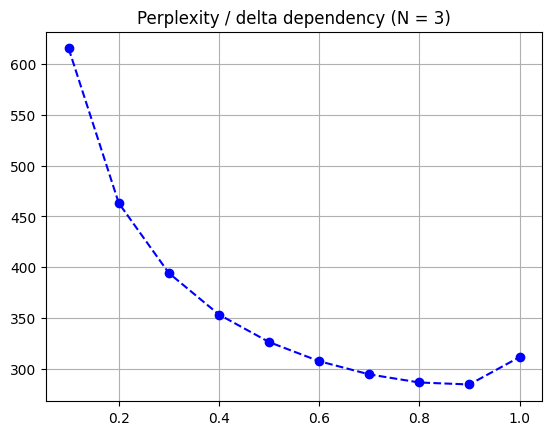

In [53]:
plt.plot(np.linspace(0.1, 1.0, 10), perp, 'bo--')
plt.grid()
plt.title('Perplexity / delta dependency (N = 3)')
plt.show()